In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
from time import time

In [2]:
NumTrials = 1

D = 3
dim = 2
tau = 1
sigma = 0.06

In [3]:
def manfit_ours(sample, sig, sample_init, op_average=1):
    Mout = np.copy(sample_init)
    N = sample_init.shape[0]
    N0 = sample.shape[0]
    ns = np.arange(1, N0 + 1)

    r = 5 * sig / np.log10(N0)
    R = 10 * sig * np.sqrt(np.log(1 / sig)) / np.log10(N0)

    for ii in range(N):
      
        x = sample_init[ii, :]

        dists = squareform(pdist(np.vstack([x, sample])))[0, 1:]

        IDX1 = dists < 2 * r
        IDX1 = ns[IDX1]

        nbrs = NearestNeighbors(n_neighbors=5).fit(sample)
        IDX2 = nbrs.kneighbors(x.reshape(1, -1), return_distance=False).flatten()

        IDX = np.union1d(IDX1, IDX2)

        BNbr = sample[IDX - 1, :]

        xbar = np.mean(BNbr, axis=0) + np.finfo(float).eps

        dx = x - xbar
        dx = dx / np.linalg.norm(dx)

        Q = np.linalg.qr(np.column_stack([dx, np.eye(dx.size)]))[0]

        sample_s = sample - x
        sample_s = sample_s @ Q

        CNbr = (np.abs(sample_s[:, 0]) < R) & (np.sum(sample_s[:, 1:] ** 2, axis=1) < r ** 2)

        if np.sum(CNbr) > 10:
            Mout[ii, :] = np.mean(sample[CNbr, :], axis=0)
        else:
            Mout[ii, :] = xbar

    return Mout

In [4]:
np.random.seed(1)

NumSamples = 5000
NumIni = 1000

t1 = np.random.randn(3, NumSamples)
samples = t1 @ np.diag(1 / np.sqrt(np.sum(t1**2, axis=0))) + sigma * np.random.randn(3, NumSamples)

t = np.random.randn(3, 2 * NumIni)
data_ini = t @ np.diag(1 / np.sqrt(np.sum(t**2, axis=0))) + 2 * sigma / np.sqrt(D) * (2 * np.random.rand(3, 2 * NumIni) - 1)
proj_data_ini = data_ini * (tau / np.sqrt(np.sum(data_ini**2, axis=0)))
norm_n2 = np.sum((data_ini - proj_data_ini)**2, axis=0)
Index = np.argsort(norm_n2)[::-1]
data_ini = data_ini[:, Index[:NumIni]]

tic = time()
Mout = manfit_ours(samples.T, sigma, data_ini.T)
Mout = Mout.T
toc = time() - tic

proj_Mout = Mout * (tau / np.sqrt(np.sum(Mout**2, axis=0)))            

(-1.2, 1.2, -1.2, 1.2)

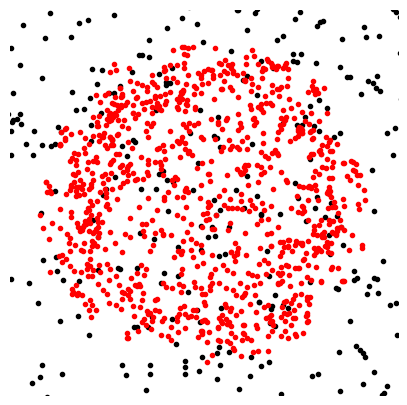

In [12]:
fig_width = 5  # Set the desired width in inches
fig_height = 5  # Set the desired height in inches
plt.figure(figsize=(fig_width, fig_height))
proj_Mout = Mout * (tau / np.sqrt(np.sum(Mout**2, axis=0)))
plt.plot(proj_Mout[0, :], proj_Mout[1, :], 'k.')
plt.plot(Mout[0, :], Mout[1, :], 'r.')
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])
plt.box(False)
plt.axis('off')